[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Space-Dream-42/brainTumourProject/blob/main/Code/First_Model_UNet.ipynb)

## First approach: UNet  

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.optim import Adam

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import SimpleITK as sitk

from Dataset_Utils import BraTS_TrainingDataset
from Dataset_Utils import BraTS_TestDataset
from Dataset_Utils import plot_batch

from unet_short import UNet
from mateusbuda_utils import dsc, dsc_per_volume
from mateusbuda_loss import DiceLoss
device = 'cuda:0'

In [2]:
torch.manual_seed(0)

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

## Data loading setup

In [5]:
# PATH
dataset_path = '../Task01_BrainTumour/cropped'

train_data = BraTS_TrainingDataset(dataset_path, 84, 42)
test_data = BraTS_TestDataset(dataset_path, 84, 42)

../Task01_BrainTumour/cropped\imagesTr
../Task01_BrainTumour/cropped\labelsTr
../Task01_BrainTumour/cropped\imagesTr
../Task01_BrainTumour/cropped\labelsTr


In [6]:
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=20, shuffle=True)

testloader = torch.utils.data.DataLoader(
    test_data, batch_size=20, shuffle=True)

train_iter = iter(trainloader)
test_iter = iter(testloader)

In [7]:
sample_batch = test_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)
# plot_batch(sample_batch, num_rows=2, height=75)

torch.Size([20, 4, 155, 192, 192])
torch.Size([20, 1, 155, 192, 192])


## Create the model

In [8]:
# predefined models:
# https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
# https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb

# unet implementation
# https://github.com/milesial/Pytorch-UNet

In [9]:
# taken from https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook


In [11]:
device = 'cuda:0'
loaders = {"train": trainloader, "valid": testloader}
unet = UNet(in_channels=4, out_channels=4, init_features=32)
unet.to(device)
dice_loss = DiceLoss()
best_validation_dsc = 0.0
optimizer = optim.Adam(unet.parameters(), lr=0.0001)
loss_train = []
overall_loss = []

step = 0


for epoch in range(1):
    for phase in ["train"]:
        if phase == "train":
            unet.train()
        else:
            unet.eval()

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1
            print(step*20)
            x_whole = data['image']
            y_true_whole = data['label']
            loss_train = []
            for i in range(len(x_whole[0, 0])):
                x, y_true = x_whole[:, :, i, :, :].to(device), y_true_whole[:, :, i, :, :].to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)
                    y_true = y_true[:, 0, :, :].type(torch.LongTensor).to(device)
                    loss = dice_loss(y_pred, y_true)
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
            overall_loss.append(np.mean(loss_train))
        torch.save(unet.state_dict(), '../Saved_Models/model_weights_%i' % epoch)

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460


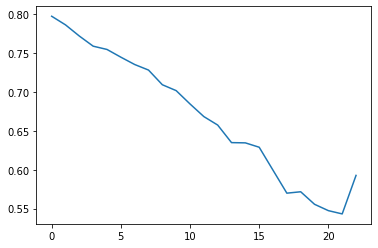

In [13]:
plt.plot(range(23), overall_loss)
plt.show()

In [15]:
unet_loaded = UNet(in_channels=4, out_channels=4, init_features=32)
unet_loaded.load_state_dict(torch.load('../Saved_Models/model_weights_0'))
_ = unet_loaded.to(device)

# Evaluation

mean of the % of the intercept of all classes:

In [16]:
class Dice_Metric(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice_Metric, self).__init__()

    def forward(self, inputs, targets):
        
        loss_count = []
        for i in range(len(inputs[0])):
            current_class = targets.clone()
            current_class[current_class!=i] = 0
            current_class[current_class==i] = 1
            loss_count.append(1-dice_loss_one_image(inputs[:, i], current_class).cpu().item())
        
        return loss_count

In [17]:
#evaluation
dice_loss = Dice_Metric()
loss_test = []
loaders = {"train": trainloader, "valid": testloader}
for i, data in enumerate(loaders['valid']):
    x_whole = data['image']
    y_true_whole = data['label']
    for i in range(len(x_whole[0, 0])):
        x, y_true = x_whole[:, :, i, :, :].to(device), y_true_whole[:, :, i, :, :].to(device)
        with torch.set_grad_enabled(False):
            y_pred = unet_loaded(x)
            y_true = y_true[:, 0, :, :].type(torch.LongTensor).to(device)
            loss = dice_loss(y_pred, y_true)
            loss_test.append(loss)
background_loss = np.mean([x[0] for x in loss_test])
edema_loss = np.mean([x[1] for x in loss_test])
non_enhance_loss = np.mean([x[2] for x in loss_test])
enhance_loss = np.mean([x[3] for x in loss_test])
print('Background: %f, edema: %f, non-enhancing tumor: %f, enhancing tumor: %f '% (background_loss, edema_loss, non_enhance_loss, enhance_loss))

KeyboardInterrupt: 

In [18]:
batch_slices = sample_batch['image']
batch_slices = batch_slices[:, :, 70, :, :].to(device)
output = unet_loaded(batch_slices)
output_array = torch.round(torch.sigmoid(output[0])).detach().cpu().numpy()
print(output_array[0].shape)
print(output.shape)

(192, 192)
torch.Size([20, 4, 192, 192])


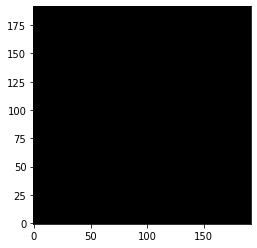

In [19]:
plt.imshow(output_array[1], cmap="gray", origin="lower")

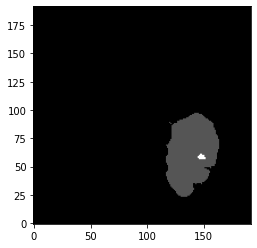

In [20]:
plt.imshow(sample_batch['label'][0,0,70,:,:], cmap="gray", origin="lower")